In [1]:
import pickle
import numpy as np
import pandas as pd
import nltk
import string
import sys
import matplotlib.pyplot as plt

from math import log2
from scipy.sparse import dok_matrix, csr_matrix, dok_array, hstack, vstack
from scipy.spatial.distance import cosine, euclidean
from scipy.sparse.linalg import svds, inv

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import TruncatedSVD, PCA

## Term-term co-occurence matrix

#### Will try to identifie words with similar meaning.
 - We will the abstracts data for this study
 
1. The data will be preprocessed
2. The Co-ocurrence matrix will be computed

### Preprocessing the data
 - Removal of punctuation
 - Filtering for only alpha-numeric values
 - Conversion to lower case

In [2]:
summaries = pd.read_csv("data/arxiv_data.csv").summaries

In [3]:
summaries = summaries.apply(lambda x: x.replace("\n", " "))

In [4]:
nltk.tokenize.sent_tokenize(summaries.loc[0])

['Stereo matching is one of the widely used techniques for inferring depth from stereo images owing to its robustness and speed.',
 'It has become one of the major topics of research since it finds its applications in autonomous driving, robotic navigation, 3D reconstruction, and many other fields.',
 'Finding pixel correspondences in non-textured, occluded and reflective areas is the major challenge in stereo matching.',
 'Recent developments have shown that semantic cues from image segmentation can be used to improve the results of stereo matching.',
 'Many deep neural network architectures have been proposed to leverage the advantages of semantic segmentation in stereo matching.',
 'This paper aims to give a comparison among the state of art networks both in terms of accuracy and in terms of speed which are of higher importance in real-time applications.']

In [8]:
def get_words(document: list[str]):
    """
    Given a document, parses it's tokens, removing stopwords and punctuation;
    """
    stopwords = set(map(str.lower, nltk.corpus.stopwords.words("english")))
    punctuation = set(string.punctuation)
    for word in nltk.tokenize.word_tokenize(document):
        word = word.lower()
        if (word not in stopwords) and \
        (word not in punctuation):
            yield word

In [9]:
all_words = {}
docs = []
index = 0
for abstract in summaries:
    for sentence in nltk.tokenize.sent_tokenize(abstract):
        current_sentence = []
        for word in get_words(sentence):
            if word not in all_words:
                all_words|= {word:index}
                index+=1
            current_sentence.append(word)
        docs.append(current_sentence)

In [10]:
len(all_words)

100649

In [11]:
with open("data/arxiv_abstracts_no_stopwords.pickle", "wb") as f:
    pickle.dump((all_words, docs), f)

### Computation of the co-ocurrence matrix with a sliding window of size {wsize}

In [2]:
all_words, docs = pickle.load(open("data/arxiv_abstracts_no_stopwords.pickle", "rb"))

In [3]:
rev_words = { item[1]:item[0] for item in all_words.items() }

In [4]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

In [5]:
M = len(all_words)
M

100680

In [6]:
wsize = 10

In [7]:
def count_word_coocurrence(docs, threshold = 50, wsize=10):
    term_term_dict = {}
    for doc in docs:
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                term_term_dict[ (prev_word, current_word) ] = term_term_dict.get(
                    (prev_word, current_word),
                    0
                ) + 1
                term_term_dict[ (future_word, current_word) ] = term_term_dict.get(
                    (future_word, current_word),
                    0
                ) + 1
                
    term_term_sparse = dok_matrix((M,M))
    for idx, value in term_term_dict.items():
        i, j = idx
        if value > threshold:
            term_term_sparse[i, j] = value
        
    return term_term_sparse

In [8]:
word_cooc_count = count_word_coocurrence(docs, threshold=0, wsize=5)

### Transforming the Sparse Co-occurence matrix into a N-Dim dense matrix using SVD

In [9]:
word_cooc_count

<100680x100680 sparse matrix of type '<class 'numpy.float64'>'
	with 6888429 stored elements in Dictionary Of Keys format>

In [10]:
u = TruncatedSVD(n_components=100).fit_transform(word_cooc_count)

In [11]:
[int2word(i) for i in range(1000,1005)]

['cnn', 'pyramidal', 'pyramid', 'pmtrans', 'captured']

In [35]:
np.argsort([ 
    euclidean(
        u[word2int("programming")], 
        u[i]
    ) for i in range(len(u))
])[:15]

array([ 1942,  4731, 12929,  4028,  1239,  3643,  3604,  1199,  1869,
         555,  2552,  1866,  7578,   305,  3262], dtype=int64)

In [56]:
tempw = int2word(3643)
tempw 

'index'

In [13]:
temp = word2int("cnn")
temp

1000

In [48]:
cnn_near = np.argsort([ 
    euclidean(
        u[word2int("cnn")], 
        u[i]
    ) for i in range(len(u))
])[:15]

In [49]:
random = np.random.choice(list(range(len(u))), size=15, replace=False)

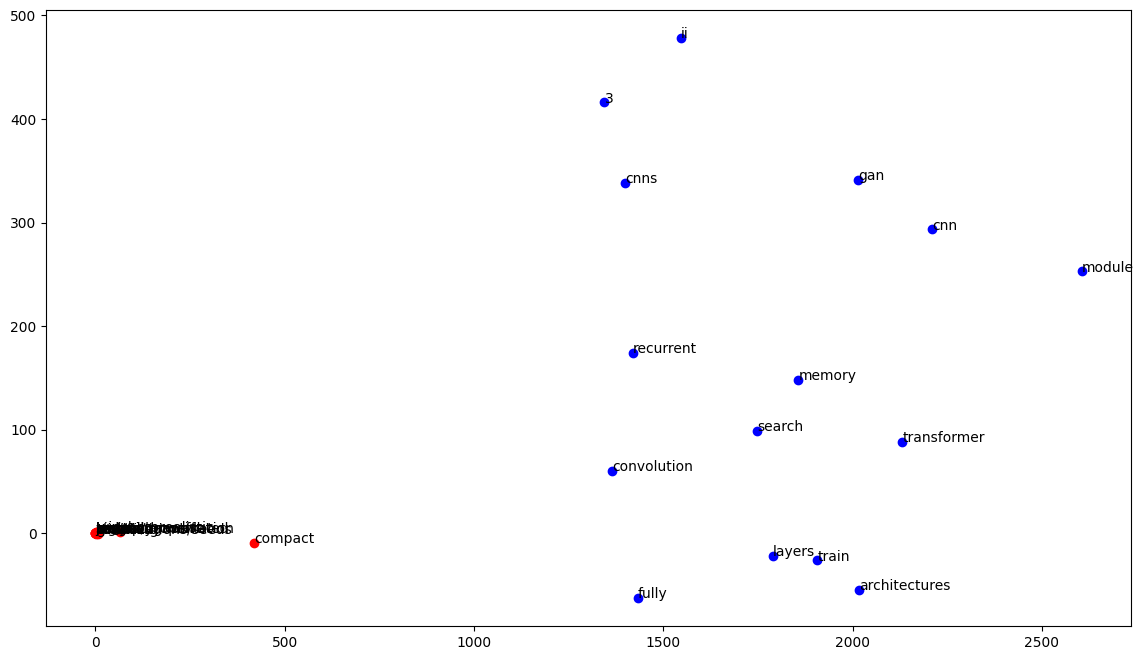

In [50]:

plt.figure(figsize=(14,8))
for i in cnn_near:
    plt.scatter(u[i,0], u[i,1], c="b") #int2word(i))
    plt.text(u[i,0], u[i,1],int2word(i))
    
for i in random:
    plt.scatter(u[i,0], u[i,1], c="r") 
    plt.text(u[i,0], u[i,1],int2word(i))

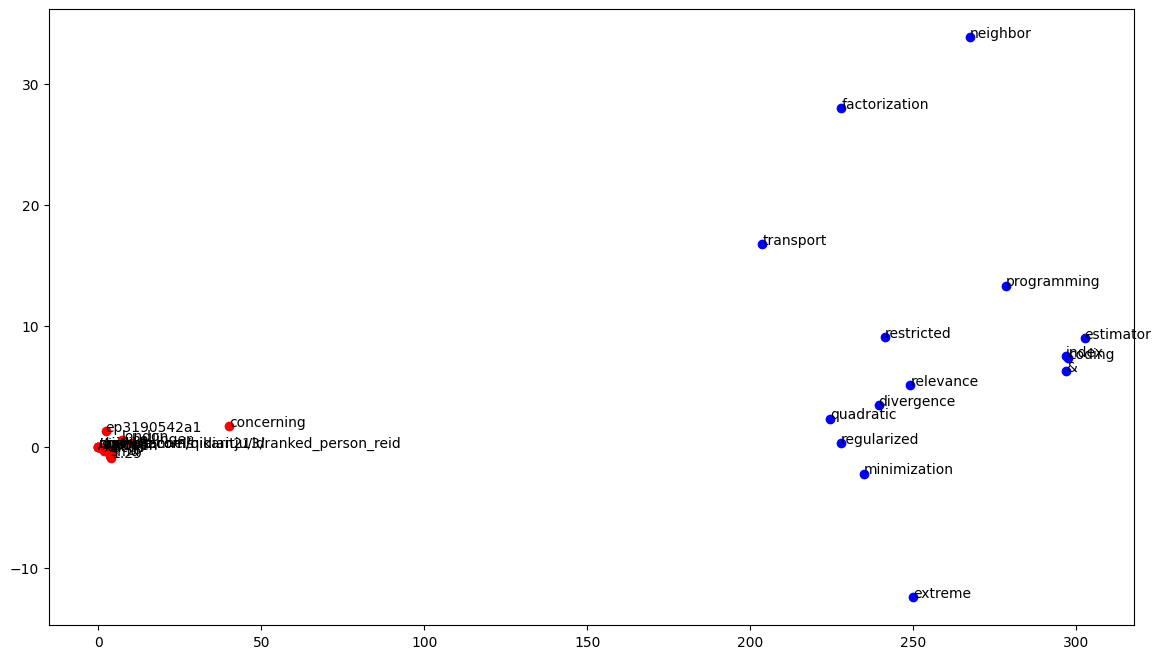

In [52]:
prog_near = np.argsort([ 
    euclidean(
        u[word2int("programming")], 
        u[i]
    ) for i in range(len(u))
])[:15]

random = np.random.choice(list(range(len(u))), size=15, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(u[i,0], u[i,1], c="b") #int2word(i))
    plt.text(u[i,0], u[i,1],int2word(i))
    
for i in random:
    plt.scatter(u[i,0], u[i,1], c="r") 
    plt.text(u[i,0], u[i,1],int2word(i))

We can see that the words are close to words that have similar meanings, for example the 'cnn' is around words related to neural networks

The closest word to "programming" is the word "coding".